# 17 DQN (Deep Q-Network) Image Process and Environment Manager 

In [1]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 16.2 Set up display
print('Setup Display...')
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

Import Library...

Setup Display...


# 17.1 Reinforcement Learning Agent

In [2]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 16.2 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

Import Library...

Setup Display...

Define class Agent():


# 17.2: Environment Manager 
## 17.2 Define class Environment Manager
## 17.3: Define Wrapped Functions
## 17.4: Define function for Number of Actions in the Environment
## 17.5: Define function for Take an Action in the Environment
## 17.6: Define function for Start Episode
## 17.7: Define function for Get State of Environment
## 17.8: Define function for Get Screen Dimension
## 17.9: Define function for Process Screen
## 17.10: Define function for Crop Screen Image
## 17.11: Define function for Convert and Rescale Screen Image

In [4]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...


# 17.12 Example of Screens

We defined all the function for class CartPoleEnvManager().

Below is the testing of the result.

# 17.13 Non-Processed Screen

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...

Non-Processed Screen...



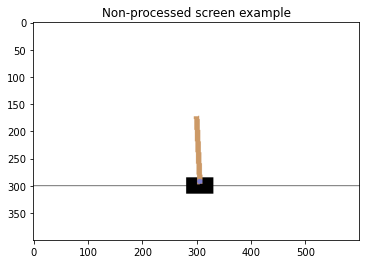

In [16]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
print()
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

# 7.13 Non-Processed Screen
print('Non-Processed Screen...')
print()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

In [ ]:
# 17.14 Processed Screen

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...

Processed Screen...


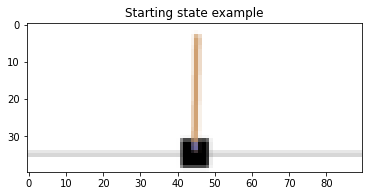

In [15]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
print()
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

# 7.14 Processed Screen
print('Processed Screen...')
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

# 17.15 Starting State

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...
Starting Screen...


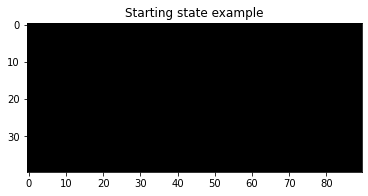

In [13]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

# 7.15 Starting State
print('Starting Screen...')
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

In [ ]:
# 17.16 Non-starting state

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...

Processed Screen...


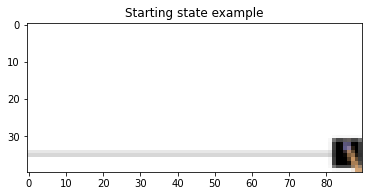

Non-Starting State...


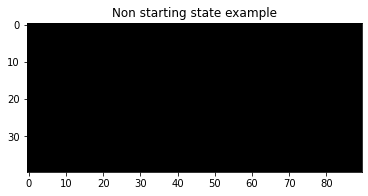

In [24]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
print()
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

# 17.14 Processed State
print('Processed Screen...')
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

# 17.16 Non-Satrting State
print('Non-Starting State...')
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

# 17.17 End State

Import Library...

Setup Display...

Define class Agent():

Define class CartPoleEnvManager...

Processed Screen...



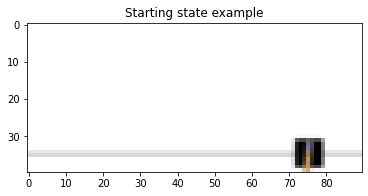

Non-Starting State...



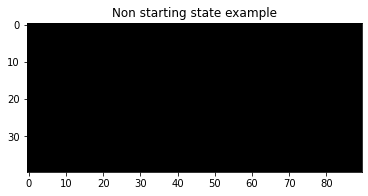

End State...



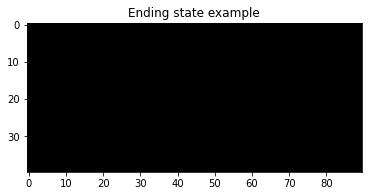

In [23]:
# Setup: Import Libraries
print('Import Library...')
print()
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## https://github.com/pytorch/vision
## conda install torchvision -c pytorch

# https://stackoverflow.com/questions/59621736/despite-installing-the-torch-vision-pytorch-library-i-am-getting-an-error-sayin
# conda install pytorch torchvision cpuonly -c pytorch
import torchvision.transforms as T

# 17.1 Set up display
print('Setup Display...')
print()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

print('Define class Agent():')
print()
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

print('Define class CartPoleEnvManager...')
print()
## 17.2 Define class Environment Manager
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    ## 17.3: Define Wrapped Functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    ## 17.4: Define function for Number of Actions in the Environment
    def num_actions_available(self):
        return self.env.action_space.n
        
    ## 17.5: Define function for Take an Action in the Environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    ## 17.6: Define function for Start Episode
    def just_starting(self):
        return self.current_screen is None
    
    ## 17.7: Define function for Get State of Environment
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    ## 17.8: Define function for Get Screen Dimension
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    ## 17.9: Define function for Process Screen   
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    ## 17.10: Define function for Crop Screen Imagee
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    ## 17.11: Define function for Convert and Rescale Screen Image
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

# 17.14 Processed State
print('Processed Screen...')
print()
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

# 17.16 Non-Satrting State
print('Non-Starting State...')
print()
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

# 17.17 End State
print('End State...')
print()
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

# 17.18 Utility functions: Plotting

In [26]:
# 17.18 Deifne plot function
print('Define Function Plot()...')
print()
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

print('Define Function get_moving_average(period, values)...')
print()
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

Define Function Plot()...

Define Function get_moving_average(period, values)...



# 17.19 Example Plot

Define Function Plot()...

Define Function get_moving_average(period, values)...

Plot...


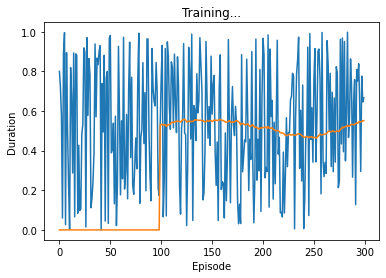

Episode 300 
 100 episode moving avg: 0.5512589


In [27]:
# 17.18 Deifne plot function
print('Define Function Plot()...')
print()
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

print('Define Function get_moving_average(period, values)...')
print()
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

print('Plot...')
plot(np.random.rand(300), 100)